In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt
import warnings
import re
import cloudscraper
warnings.filterwarnings("ignore")

In [19]:

scraper = cloudscraper.create_scraper()

url = ('https://fbref.com/en/squads/639950ae/2025/matchlogs/c24/schedule/Flamengo-Scores-and-Fixtures-Serie-A')

# 1) Busca o HTML da página
html = scraper.get(url).text
soup = BeautifulSoup(html, "html.parser")

# 2) Extrai o título completo e isola só o nome do time
full_title = soup.find("h1").get_text(strip=True)
m = re.match(r"^\d{4}\s+(.+?)\s+Scores", full_title)
team_name = m.group(1) if m else full_title

# 3) Lê a tabela de Scores & Fixtures
df = pd.read_html(html, flavor='lxml')[0]


# 4) Remove linhas sem resultado ou sem xG/xGA
df = df.dropna(subset=["Result", "xG", "xGA"])

# 5) Seleciona colunas úteis (incluindo 'Poss' e 'Opponent')
df = (
    df.rename(columns=str.strip)
      .loc[:, ["Date", "Result", "GF", "GA", "xG", "xGA", "Poss", "Opponent", "Round", "Day", "Venue", "Referee", "Attendance"]]
      .copy()
)

# 6) Converte datas 
if "Date" in df.columns:
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True, errors="coerce")
df["Team"] = team_name

# 7) Imprime o DataFrame
df

,Date,Result,GF,GA,xG,xGA,Poss,Opponent,Round,Day,Venue,Referee,Attendance,Team
0,2025-03-29,D,1.0,1.0,1.8,0.4,62.0,Internacional,Matchweek 1,Sat,Home,Davi de Oliveira Lacerda,48452.0,Flamengo
1,2025-04-06,W,2.0,1.0,1.6,0.3,63.0,Vitória,Matchweek 2,Sun,Away,Rafael Klein,29493.0,Flamengo
2,2025-04-13,W,2.0,0.0,1.0,0.3,60.0,Grêmio,Matchweek 3,Sun,Away,Ramon Abatti,23367.0,Flamengo
3,2025-04-16,W,6.0,0.0,3.2,0.2,68.0,Juventude,Matchweek 4,Wed,Home,Matheus Delgado Candançan,31445.0,Flamengo
4,2025-04-19,D,0.0,0.0,2.0,0.6,64.0,Vasco da Gama,Matchweek 5,Sat,Away,Raphael Claus,39027.0,Flamengo
5,2025-04-27,W,4.0,0.0,2.2,0.3,54.0,Corinthians,Matchweek 6,Sun,Home,Ramon Abatti,67501.0,Flamengo
6,2025-05-04,L,1.0,2.0,0.3,1.2,59.0,Cruzeiro,Matchweek 7,Sun,Away,Wilton Sampaio,52792.0,Flamengo
7,2025-05-10,W,1.0,0.0,1.5,0.5,61.0,Bahia,Matchweek 8,Sat,Home,Anderson Daronco,62204.0,Flamengo
8,2025-05-18,D,0.0,0.0,0.7,0.5,59.0,Botafogo (RJ),Matchweek 9,Sun,Home,Bruno Arleu,50255.0,Flamengo
9,2025-05-25,W,2.0,0.0,1.7,1.9,50.0,Palmeiras,Matchweek 10,Sun,Away,Ramon Abatti,41075.0,Flamengo


In [20]:

from scipy.stats import poisson

def win_draw_loss_probs(xg_for, xg_against, max_goals=5):
    """
    Estima P(win), P(draw) e P(loss) usando distribuição de Poisson até max_goals.
    """
    # Distribuição de probabilidades para cada número de gols
    pf = [poisson.pmf(i, xg_for) for i in range(max_goals+1)]
    pa = [poisson.pmf(i, xg_against) for i in range(max_goals+1)]
    # Probabilidade de vitória: somatória de P(F_gols=i) * P(A_gols< i)
    p_win  = sum(pf[i] * sum(pa[:i]) for i in range(max_goals+1))
    # Empate: P(F_gols=i) * P(A_gols=i)
    p_draw = sum(pf[i] * pa[i] for i in range(max_goals+1))
    # Derrota: P(F_gols=i) * P(A_gols>i)
    p_loss = sum(pf[i] * sum(pa[i+1:]) for i in range(max_goals+1))
    return p_win, p_draw, p_loss

# 1) Calcula as probabilidades
df[["P_win","P_draw","P_loss"]] = df.apply(
    lambda row: pd.Series(win_draw_loss_probs(row["xG"], row["xGA"])),
    axis=1)

# 2) Expected Points (XP) e acumulado
df["XP"]       = 3*df["P_win"] + 1*df["P_draw"]
df["XP_acum"]  = df["XP"].cumsum()

# 3) Pontos reais e acumulado
df["Pts"]      = df["Result"].map({"W":3,"D":1,"L":0})
df["Pts_acum"] = df["Pts"].cumsum()

# Exiba o DataFrame resultante
display(df[[
    "Date","Team","Opponent",
    "Result", "Poss","xG","xGA",
    "P_win","P_draw","P_loss",
    "XP","XP_acum","Pts","Pts_acum"
]])


,Date,Team,Opponent,Result,Poss,xG,xGA,P_win,P_draw,P_loss,XP,XP_acum,Pts,Pts_acum
0,2025-03-29,Flamengo,Internacional,D,62.0,1.8,0.4,0.708417,0.206144,0.075058,2.331394,2.331394,1,1
1,2025-04-06,Flamengo,Vitória,W,63.0,1.6,0.3,0.698282,0.230450,0.065227,2.325297,4.656691,3,4
2,2025-04-13,Flamengo,Grêmio,W,60.0,1.0,0.3,0.529160,0.360632,0.109614,1.948111,6.604802,3,7
3,2025-04-16,Flamengo,Juventude,W,68.0,3.2,0.2,0.826262,0.058403,0.009927,2.537188,9.141990,3,10
4,2025-04-19,Flamengo,Vasco da Gama,D,64.0,2.0,0.6,0.688494,0.193986,0.100918,2.259469,11.401459,1,11
5,2025-04-27,Flamengo,Corinthians,W,54.0,2.2,0.3,0.790466,0.145883,0.038740,2.517280,13.918739,3,14
6,2025-05-04,Flamengo,Cruzeiro,L,59.0,0.3,1.2,0.092217,0.310982,0.595299,0.587634,14.506373,0,14
7,2025-05-10,Flamengo,Bahia,W,61.0,1.5,0.5,0.616188,0.257531,0.121811,2.106094,16.612467,3,17
8,2025-05-18,Flamengo,Botafogo (RJ),D,59.0,0.7,0.5,0.355159,0.416203,0.228534,1.481680,18.094148,1,18
9,2025-05-25,Flamengo,Palmeiras,W,50.0,1.7,1.9,0.342489,0.218253,0.418145,1.245721,19.339869,3,21


In [21]:

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# 1) Lê o DataFrame já preparado
df["Date"] = pd.to_datetime(df["Date"])

# 2) Define X e y
X = df[["xG","xGA","Poss"]]
y = df["Result"]

# 3) Converte W/D/L em códigos numéricos
le = LabelEncoder()
y_enc = le.fit_transform(y)  # ex: ['D','L','W'] → [0,1,2]

# 4) Treina o modelo multinomial
model = LogisticRegression(multi_class="multinomial", solver="lbfgs", max_iter=1000)
model.fit(X, y_enc)

# 5) Avalia no próprio conjunto
y_pred = model.predict(X)
print("=== Classification Report ===")
print(classification_report(y_enc, y_pred, target_names=le.classes_))

# 6) Exibe coeficientes por classe
coef_df = pd.DataFrame(model.coef_, index=le.classes_, columns=X.columns)
print("=== Coeficientes ===")
display(coef_df)

# 7) Gera probabilidades preditas
probs = model.predict_proba(X)
probs_df = pd.DataFrame(probs, columns=[f"P_pred_{cls}" for cls in le.classes_])

# 8) Junta tudo num resultado final
result_df = pd.concat([df.reset_index(drop=True), probs_df], axis=1)
print("\n=== Probabilidades Preditas (5 primeiras linhas) ===")
display(result_df.head())

=== Classification Report ===
              precision    recall  f1-score   support

           D       0.00      0.00      0.00         3
           L       0.00      0.00      0.00         1
           W       0.73      1.00      0.84         8

    accuracy                           0.67        12
   macro avg       0.24      0.33      0.28        12
weighted avg       0.48      0.67      0.56        12

=== Coeficientes ===


,xG,xGA,Poss
D,-0.091902,-0.005282,0.119539
L,-0.718951,0.392639,-0.033007
W,0.810853,-0.387358,-0.086532



=== Probabilidades Preditas (5 primeiras linhas) ===


,Date,Result,GF,GA,xG,xGA,Poss,Opponent,Round,Day,...,P_win,P_draw,P_loss,XP,XP_acum,Pts,Pts_acum,P_pred_D,P_pred_L,P_pred_W
0,2025-03-29,D,1.0,1.0,1.8,0.4,62.0,Internacional,Matchweek 1,Sat,...,0.708417,0.206144,0.075058,2.331394,2.331394,1,1,0.259573,0.042756,0.697670
1,2025-04-06,W,2.0,1.0,1.6,0.3,63.0,Vitória,Matchweek 2,Sun,...,0.698282,0.230450,0.065227,2.325297,4.656691,3,4,0.327752,0.050491,0.621757
2,2025-04-13,W,2.0,0.0,1.0,0.3,60.0,Grêmio,Matchweek 3,Sun,...,0.529160,0.360632,0.109614,1.948111,6.604802,3,7,0.293889,0.104232,0.601879
3,2025-04-16,W,6.0,0.0,3.2,0.2,68.0,Juventude,Matchweek 4,Wed,...,0.826262,0.058403,0.009927,2.537188,9.141990,3,10,0.249552,0.006318,0.744130
4,2025-04-19,D,0.0,0.0,2.0,0.6,64.0,Vasco da Gama,Matchweek 5,Sat,...,0.688494,0.193986,0.100918,2.259469,11.401459,1,11,0.323496,0.037515,0.638989


In [22]:
# 1) Remover espaços indesejados nos nomes das colunas
result_df.columns = result_df.columns.str.strip()

# 2) Cria a coluna de XP baseada no modelo de ML
#    XP_ml = 3 × P_pred_W + 1 × P_pred_D
result_df['XP_ml'] = 3 * result_df['P_pred_W'] + 1 * result_df['P_pred_D']

# 3) Acumula o XP_ml
result_df['XP_ml_cum'] = result_df['XP_ml'].cumsum()
display(result_df)

,Date,Result,GF,GA,xG,xGA,Poss,Opponent,Round,Day,...,P_loss,XP,XP_acum,Pts,Pts_acum,P_pred_D,P_pred_L,P_pred_W,XP_ml,XP_ml_cum
0,2025-03-29,D,1.0,1.0,1.8,0.4,62.0,Internacional,Matchweek 1,Sat,...,0.075058,2.331394,2.331394,1,1,0.259573,0.042756,0.697670,2.352585,2.352585
1,2025-04-06,W,2.0,1.0,1.6,0.3,63.0,Vitória,Matchweek 2,Sun,...,0.065227,2.325297,4.656691,3,4,0.327752,0.050491,0.621757,2.193022,4.545607
2,2025-04-13,W,2.0,0.0,1.0,0.3,60.0,Grêmio,Matchweek 3,Sun,...,0.109614,1.948111,6.604802,3,7,0.293889,0.104232,0.601879,2.099526,6.645133
3,2025-04-16,W,6.0,0.0,3.2,0.2,68.0,Juventude,Matchweek 4,Wed,...,0.009927,2.537188,9.141990,3,10,0.249552,0.006318,0.744130,2.481943,9.127076
4,2025-04-19,D,0.0,0.0,2.0,0.6,64.0,Vasco da Gama,Matchweek 5,Sat,...,0.100918,2.259469,11.401459,1,11,0.323496,0.037515,0.638989,2.240463,11.367539
5,2025-04-27,W,4.0,0.0,2.2,0.3,54.0,Corinthians,Matchweek 6,Sun,...,0.038740,2.517280,13.918739,3,14,0.044941,0.018757,0.936302,2.853846,14.221385
6,2025-05-04,L,1.0,2.0,0.3,1.2,59.0,Cruzeiro,Matchweek 7,Sun,...,0.595299,0.587634,14.506373,0,14,0.349016,0.319942,0.331042,1.342142,15.563527
7,2025-05-10,W,1.0,0.0,1.5,0.5,61.0,Bahia,Matchweek 8,Sat,...,0.121811,2.106094,16.612467,3,17,0.272795,0.065736,0.661469,2.257203,17.820730
8,2025-05-18,D,0.0,0.0,0.7,0.5,59.0,Botafogo (RJ),Matchweek 9,Sun,...,0.228534,1.481680,18.094148,1,18,0.301363,0.162710,0.535927,1.909143,19.729874
9,2025-05-25,W,2.0,0.0,1.7,1.9,50.0,Palmeiras,Matchweek 10,Sun,...,0.418145,1.245721,19.339869,3,21,0.051542,0.102413,0.846045,2.589678,22.319552


In [15]:
dif = result_df["Pts_acum"].iloc[-1] - result_df["XP_acum"].iloc[-1]
print(f"O Flamengo está com {dif:.2f} pontos a mais do que o esperado!")


O Flamengo está com 2.92 pontos a mais do que o esperado!


In [16]:
import plotly.graph_objects as go
import pandas as pd

# Garantir que a data está em datetime
df_time['Date'] = pd.to_datetime(df_time['Date'])

# Criar coluna de diferença se ainda não existir
df_time['Diferença'] = df_time['Pts'] - df_time['XP_ml']

# Criar gráfico
fig = go.Figure()

# Pontos reais
fig.add_trace(go.Scatter(
    x=df_time['Date'],
    y=df_time['Pts'],
    mode='lines+markers',
    name='Pontos Reais',
    text=df_time.apply(lambda row: f"Adversário: {row['Opponent']}<br>Resultado: {row['Result']}", axis=1),
    hovertemplate='Data: %{x|%d/%m/%Y}<br>%{text}<br>Pontos Reais: %{y}<extra></extra>'
))

# Pontos esperados
fig.add_trace(go.Scatter(
    x=df_time['Date'],
    y=df_time['XP_ml'],
    mode='lines+markers',
    name='Pontos Esperados (XP_ml)',
    text=df_time.apply(lambda row: f"Adversário: {row['Opponent']}<br>Resultado: {row['Result']}", axis=1),
    hovertemplate='Data: %{x|%d/%m/%Y}<br>%{text}<br>XP_ml: %{y:.2f}<extra></extra>'
))

# Diferença
fig.add_trace(go.Scatter(
    x=df_time['Date'],
    y=df_time['Diferença'],
    mode='lines+markers',
    name='Diferença (Pts - XP)',
    text=df_time.apply(lambda row: f"Adversário: {row['Opponent']}<br>Resultado: {row['Result']}", axis=1),
    hovertemplate='Data: %{x|%d/%m/%Y}<br>%{text}<br>Diferença: %{y:.2f}<extra></extra>'
))

# Layout
fig.update_layout(
    title='Pontos Reais vs Esperados (Flamengo)',
    xaxis_title='Data',
    yaxis_title='Pontos',
    hovermode='x unified',
    template='plotly_white',
    legend_title='Métricas'
)

fig.show()

In [17]:
df_time

,Date,Result,GF,GA,xG,xGA,Poss,Opponent,Team,P_win,...,Pts,Pts_acum,P_pred_D,P_pred_L,P_pred_W,XP_ml,XP_ml_cum,diff_real_xp,hover_text,Diferença
0,2025-03-29,D,1.0,1.0,1.8,0.4,62.0,Internacional,Flamengo,0.708417,...,1,1,0.259573,0.042756,0.697670,2.352585,2.352585,-1.331394,Data: 29/03/2025<br>Adversário: Internacional<...,-1.352585
1,2025-04-06,W,2.0,1.0,1.6,0.3,63.0,Vitória,Flamengo,0.698282,...,3,4,0.327752,0.050491,0.621757,2.193022,4.545607,-0.656691,Data: 06/04/2025<br>Adversário: Vitória<br>Res...,0.806978
2,2025-04-13,W,2.0,0.0,1.0,0.3,60.0,Grêmio,Flamengo,0.529160,...,3,7,0.293889,0.104232,0.601879,2.099526,6.645133,0.395198,Data: 13/04/2025<br>Adversário: Grêmio<br>Resu...,0.900474
3,2025-04-16,W,6.0,0.0,3.2,0.2,68.0,Juventude,Flamengo,0.826262,...,3,10,0.249552,0.006318,0.744130,2.481943,9.127076,0.858010,Data: 16/04/2025<br>Adversário: Juventude<br>R...,0.518057
4,2025-04-19,D,0.0,0.0,2.0,0.6,64.0,Vasco da Gama,Flamengo,0.688494,...,1,11,0.323496,0.037515,0.638989,2.240463,11.367539,-0.401459,Data: 19/04/2025<br>Adversário: Vasco da Gama<...,-1.240463
5,2025-04-27,W,4.0,0.0,2.2,0.3,54.0,Corinthians,Flamengo,0.790466,...,3,14,0.044941,0.018757,0.936302,2.853846,14.221385,0.081261,Data: 27/04/2025<br>Adversário: Corinthians<br...,0.146154
6,2025-05-04,L,1.0,2.0,0.3,1.2,59.0,Cruzeiro,Flamengo,0.092217,...,0,14,0.349016,0.319942,0.331042,1.342142,15.563527,-0.506373,Data: 04/05/2025<br>Adversário: Cruzeiro<br>Re...,-1.342142
7,2025-05-10,W,1.0,0.0,1.5,0.5,61.0,Bahia,Flamengo,0.616188,...,3,17,0.272795,0.065736,0.661469,2.257203,17.820730,0.387533,Data: 10/05/2025<br>Adversário: Bahia<br>Resul...,0.742797
8,2025-05-18,D,0.0,0.0,0.7,0.5,59.0,Botafogo (RJ),Flamengo,0.355159,...,1,18,0.301363,0.162710,0.535927,1.909143,19.729874,-0.094148,Data: 18/05/2025<br>Adversário: Botafogo (RJ)<...,-0.909143
9,2025-05-25,W,2.0,0.0,1.7,1.9,50.0,Palmeiras,Flamengo,0.342489,...,3,21,0.051542,0.102413,0.846045,2.589678,22.319552,1.660131,Data: 25/05/2025<br>Adversário: Palmeiras<br>R...,0.410322


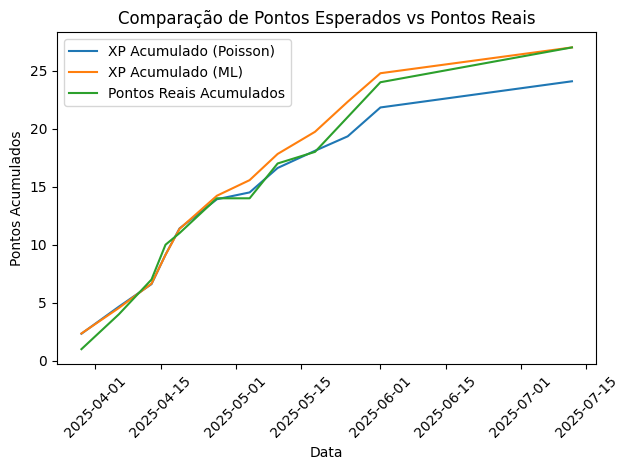

In [18]:
import matplotlib.pyplot as plt

# Configura a figura
plt.figure()

# Plota os acumulados
plt.plot(result_df['Date'], result_df['XP_acum'], label='XP Acumulado (Poisson)')
plt.plot(result_df['Date'], result_df['XP_ml_cum'], label='XP Acumulado (ML)')
plt.plot(result_df['Date'], result_df['Pts_acum'], label='Pontos Reais Acumulados')

# Legenda e rótulos
plt.legend()
plt.title('Comparação de Pontos Esperados vs Pontos Reais')
plt.xlabel('Data')
plt.ylabel('Pontos Acumulados')
plt.xticks(rotation=45)

# Ajusta layout e exibe
plt.tight_layout()
plt.show()
